# Regulome Explorer 2.X
Comparison of the average gene expression of two groups based on clinical data (catageorical)


### Authenticate with Google  (IMPORTANT)
Our first step is to authenticate with Google -- you will need to be a member of a Google Cloud Platform (GCP) project, with authorization to run BigQuery jobs in order to run this notebook.  If you don't have access to a GCP project, please contact the ISB-CGC team for help (www.isb-cgc.org)

#### Import Python libraries

In [160]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
from scipy import stats

#### Python convenience functions

- **`runQuery`**: a relatively generic BigQuery query-execution wrapper function which can be used to run a query in "dry-run"  mode or not:  the call to the `query()` function itself is inside a `try/except` block and if it fails we return `None`;  otherwise a "dry" will return an empty dataframe, and a "live" run will return the query results as a dataframe.  This function was modify from previous notebooks to handle user-defined parameteres necessary for the purpose of this notbeook.



In [161]:
def runQuery ( client, qString, ParameterList1, ParameterList2, ParameterList3, dryRun=False ):
  
  print ( "\n in runQuery ... " )
  if ( dryRun ):
    print ( "    dry-run only " )
    
  ## set up QueryJobConfig object
  job_config = bigquery.QueryJobConfig()
    
  query_params = [
        bigquery.ArrayQueryParameter('PARAMETERLIST1', 'STRING', ParameterList1 ),
        bigquery.ArrayQueryParameter('PARAMETERLIST2', 'STRING', ParameterList2 ),
        bigquery.ArrayQueryParameter('PARAMETERLIST3', 'STRING', ParameterList3 )
  ]
  job_config.query_parameters = query_params  
    
  job_config.dry_run = dryRun
  job_config.use_query_cache = True
  job_config.use_legacy_sql = False
  
  ## run the query
  try:
    query_job = client.query ( qString, job_config=job_config )
    ## print ( "    query job state: ", query_job.state )
  except:
    print ( "  FATAL ERROR: query execution failed " )
    return ( None )
  
  ## return results as a dataframe (or an empty dataframe for a dry-run) 
  if ( not dryRun ):
    try:
      df = query_job.to_dataframe()
      if ( query_job.total_bytes_processed==0 ):
        print ( "    the results for this query were previously cached " )
      else:
        print ( "    this query processed {} bytes ".format(query_job.total_bytes_processed) )
      if ( len(df) < 1 ):
        print ( "  WARNING: this query returned NO results ")
      return ( df )
    except:
      print ( "  FATAL ERROR: query execution failed " )
      return ( None )
    
  else:
    print ( "    if not cached, this query will process {} bytes ".format(query_job.total_bytes_processed) )
    ## return an empty dataframe
    return ( pd.DataFrame() )

### SQL Building Functions


**`build_expdata`**. This function outputs a query string to create a table with three columns: patient ID, gene expresion, and gene name, for a user defined list of genes (PARAMETERLIST1) or all genes with gene expression data. Since a patient can have multiple samples, the gene expression value for each patient is averaged over the respective samples. 

In [162]:
def build_expdata ( study ):
  qString = """
  expdata AS (
       SELECT      
           participantBarcode as patientid,
           Symbol,
           AVG( LOG10( normalized_count +1 )  ) as gene_exp
       FROM
          `pancancer-atlas.Filtered.EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_filtered` 
       WHERE
           #study = '__study__' AND Symbol IN UNNEST(@PARAMETERLIST1)
           study = '__study__' AND Symbol IS NOT NULL
       GROUP BY ParticipantBarcode, Symbol
  )""".replace('__study__',study)
  return qString
    

**`build_statdata`**. This function outputs a query string to create a table with four columns: gene_name, category, n, sumx, and sumx2. n is the number of patients with the same clinical category, sumx (sumx2) is the sum of the gene expression (squared) data over all patients with the same category. 

In [163]:
def build_statdata( category ):
  qString ="""
  statdata AS (
       SELECT
           A.Symbol,
           B.__category__ as category,
           COUNT( A.patientid ) as n,
           SUM( A.gene_exp ) as sumx,
           SUM( A.gene_exp * A.gene_exp ) as sumx2
       FROM
           expdata A
       INNER JOIN `pancancer-atlas.Filtered.clinical_PANCAN_patient_with_followup_filtered`  B
           ON A.patientid = B.bcr_patient_barcode
       GROUP BY
           B.__category__, A.Symbol     
  )""".replace('__category__', category)    
  return qString  

**`build_groupdate`**. Outputs a query string that summarize the statistical data for the desired catageory values  that are specified for group1 and group 2.  This catagory values are defined by a couple parameter lists, PARAMETERLIST2 and PARAMETERLIST3 for group 1 and group 2 respectively.

In [164]:
def build_groupdate():
  qString ="""
  group1 AS (
       SELECT Symbol, SUM( n ) as n, SUM( sumx ) as sumx, SUM( sumx2 ) as sumx2
       FROM statdata 
       WHERE category IN UNNEST(@PARAMETERLIST2)
       GROUP BY Symbol           
  ),
  group2 AS (
       SELECT Symbol, SUM( n ) as n, SUM( sumx ) as sumx, SUM( sumx2 ) as sumx2
       FROM statdata 
       WHERE category IN UNNEST(@PARAMETERLIST3)
       GROUP BY Symbol           
  )
  """  
  return qString

##  Start the analysis

In [165]:
# Start by getting authorized.
bqclient = bigquery.Client()

###  Specify Parameters

In [166]:
study = 'ACC' # Select Tumor type 
ClinicFeature1 = 'pathologic_stage'  # Clinical feature 
#gene_list =['IGF2','ADAM6','GRWD1','PATE3','CASP8'] #gene nems, irrelevant if all genes are evaluated
group1 = [ 'Stage I', 'Stage II']   # Category values to define group 1
group2 = ['Stage III', 'Stage IV']  # Category values to define group 1


### Obtain data from Bigquery
We retreive data for t test evaluation. The ouput of the code is a dataframe with 7 columns corresponding to gene name (Symbol), the number of samples, average expression and variance of the two groups.
This computation can take several seconds.

In [167]:
# Build the sql code
sql = (
"""WITH
"""+
build_expdata( study ) + ',\n' + 
build_statdata( ClinicFeature1 ) + ',\n' +
build_groupdate() + '\n' +    
"""
SELECT 
  A.Symbol,
  A.n as n1, (A.sumx/A.n) as avg1 , (A.sumx2 - A.sumx*A.sumx/A.n)/(A.n - 1) as var1 ,
  B.n as n2, (B.sumx/B.n) as avg2 , (B.sumx2 - B.sumx*B.sumx/B.n)/(B.n - 1) as var2
FROM 
  group1 A
INNER JOIN
  group2 B
ON   
  A.Symbol  = B.Symbol 
"""
)

# bigquery 
res0 = runQuery ( bqclient, sql, gene_list, group1, group2, dryRun=False )


 in runQuery ... 
    the results for this query were previously cached 


We can now take a look the computed statistics. We have to make sure that there is not NUL values which may indicate that a group has no elements.

In [168]:
res0[0:10]

,Symbol,n1,avg1,var1,n2,avg2,var2
0,TNIP2,46,2.721017,0.032786,30,2.724020,0.023377
1,AP1G1,46,3.370978,0.014340,30,3.346823,0.029890
2,C14orf178,46,0.162027,0.030331,30,0.176604,0.034447
3,UBASH3B,46,1.566646,0.122094,30,1.533723,0.125481
4,PFKFB4,46,2.533325,0.232271,30,2.699664,0.241280
5,POU3F2,46,0.649067,0.366423,30,0.808881,0.471779
6,LOC100132831,46,0.101804,0.019569,30,0.121566,0.025672
7,NKAP,46,2.806441,0.020916,30,2.789437,0.032605
8,C6orf162,46,2.164080,0.031893,30,2.145919,0.029427
9,CXCL10,46,1.336228,0.318461,30,1.342521,0.510212


###  Analyze the results
We can now use python function to the data in the resulting dataframe (res0). For example we can compute t-scores and p-values to determine if the difference between the mean of the two groups is statistically significant

In [169]:
# t statistics
f = lambda n1,n2,avg1,avg2,var1,var2  : (avg1 - avg2) / np.sqrt(var1/float(n1) + var2/float(n2) ) 
res0['tscore'] = res0.apply(lambda x: f(x.n1,x.n2,x.avg1,x.avg2,x.var1,x.var2), axis=1)

# p value 
f = lambda  n1,n2,tscore :  (1.0 -  stats.t.cdf(abs(tscore), n1 + n2 - 2 )) * 2.0 
res0['pvalue'] = res0.apply(lambda x: f(x.n1,x.n2,x.tscore), axis=1)

res0.sort_values( by= 'pvalue')[0:10]

/Users/borisaguilar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


,Symbol,n1,avg1,var1,n2,avg2,var2,tscore,pvalue
6740,DCAF15,46,2.791652,0.021481,30,3.001801,0.021450,-6.112562,4.211413e-08
2810,C14orf80,46,1.972242,0.065065,30,2.327349,0.060538,-6.061233,5.213308e-08
5810,HAUS8,46,2.022837,0.103465,30,2.398931,0.062825,-5.706652,2.243011e-07
11548,CENPJ,46,1.993653,0.035947,30,2.218451,0.026015,-5.536444,4.472172e-07
9086,DPF1,46,0.717971,0.338007,30,1.341653,0.161269,-5.529146,4.605700e-07
17069,MCM10,46,1.390464,0.201234,30,1.940207,0.175986,-5.432395,6.793837e-07
13006,PTCH2,46,1.237971,0.119995,30,1.734555,0.181423,-5.337440,9.924677e-07
17115,POLD1,46,2.596990,0.053311,30,2.857353,0.037465,-5.306079,1.124178e-06
11638,TRIP13,46,1.905145,0.174519,30,2.404135,0.152228,-5.298768,1.157266e-06
1901,UBE2S,46,2.703592,0.117995,30,3.069638,0.069413,-5.240540,1.457236e-06


We can plot the data

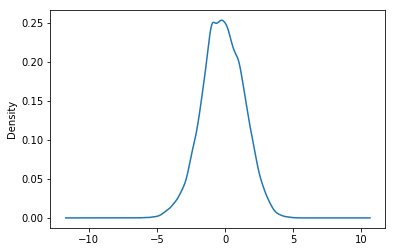

In [170]:
res0['tscore'].plot.kde()